<a href="https://colab.research.google.com/github/podo47/DL_HW3_Pytorch_TF/blob/main/DL_HW3_LeNet5_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch

## Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Import library

In [ ]:
import os
import math
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import time
import pickle
from tqdm import tqdm

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
!pip install thop
from thop import profile


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Show matplotlib graphs in your notebook
%matplotlib inline

## Load data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/images/train.txt', sep=" ",header=None)
train_y = np.array(train[1])

valid = pd.read_csv('/content/drive/MyDrive/images/val.txt', sep=" ",header=None)
valid_y = np.array(valid[1])

test = pd.read_csv('/content/drive/MyDrive/images/test.txt', sep=" ",header=None)
test_dir = np.array(test[0])
test_y = np.array(test[1])

In [ ]:
with np.load("/content/drive/MyDrive/images/rgb_dataset.npz") as data:
    X_train = data["traindata"]
    X_valid = data["validdata"]
    X_test = data["testdata"]

In [ ]:
print('X_train shape : ', X_train.shape)
print('X_valid shape : ',X_valid.shape)
print('X_test shape : ',X_test.shape)

X_train shape :  (63325, 28, 28, 3)
X_valid shape :  (450, 28, 28, 3)
X_test shape :  (450, 28, 28, 3)


## plot image

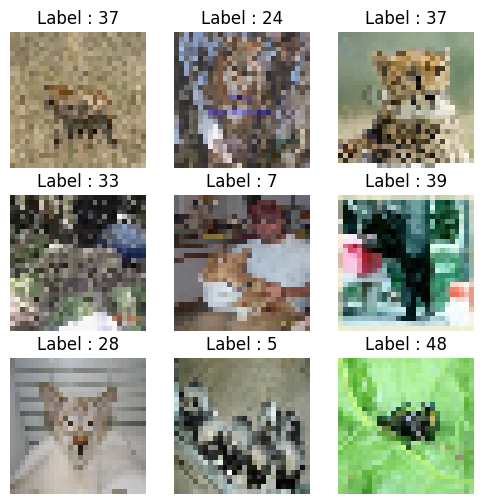

In [ ]:
fig,axs = plt.subplots(3,3,figsize = (6,6))

for idx, ax in enumerate(axs.flat):
    id = random.randint(0,X_train.shape[0])
    ax.imshow(cv2.cvtColor(X_train[id], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title('Label : {}'.format(train_y[id]))

## Define dataLoader

### Define dataset

In [ ]:
# Reshape
train_data = np.transpose(X_train,(0,3,1,2))
valid_data = np.transpose(X_valid,(0,3,1,2))
test_data = np.transpose(X_test,(0,3,1,2))

# Convert data to torch and normalize (because the input of transform.ToPILImage need to be in range [0, 1])
train_data, train_label = torch.from_numpy(train_data).to(torch.float)/255.0, torch.from_numpy(train_y.astype(int))
valid_data, valid_label = torch.from_numpy(valid_data).to(torch.float)/255.0, torch.from_numpy(valid_y.astype(int))
test_data, test_label = torch.from_numpy(test_data).to(torch.float)/255.0, torch.from_numpy(test_y.astype(int))


In [ ]:
class MyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Implements transforms

In [ ]:
# Normalization
transform1 = T.Compose(
    [T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Shifting: randomly shift the images up/down and left/right by within 10%.
transform2 = T.Compose(
    [T.RandomAffine(degrees=0, translate=(0.1,0.1)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Rotating: randomly rotate the images by some angles.
transform3 = T.Compose(
    [T.RandomRotation(degrees=45),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Flipping: horizontally flip the images.
transform4 = T.Compose(
    [T.RandomHorizontalFlip(p=1),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_list = [transform1, transform2, transform3, transform4]
augmented_dataset = []
for t in transform_list:
    augmented_dataset.append(MyDataset(train_data, train_label, transform=t ))

train_dataset = ConcatDataset(augmented_dataset)
valid_dataset = MyDataset(valid_data, valid_label, transform=transform1 )
test_dataset = MyDataset(test_data, test_label, transform=transform1 ) 


### Dataloader

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=256)
valid_loader = DataLoader(dataset=valid_dataset, shuffle=False, batch_size=450)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=450)

## LeNet5

○ Kernel size (conv): 5x5

○ Stride (cov): 1x1

○ FC layer : 120 -> 84 -> 50

In [ ]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    # TODO: define your CNN
    self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5, stride=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, 5, stride=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2)
            )
    self.fc_layers = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 50))

  def forward(self, x):
    # TODO: define your forward function
    x = self.cnn_layers(x)
    x = x.flatten(1)
    x = self.fc_layers(x)
    return x


## Train and test function

In [ ]:
def train(model, criterion, optimizer, traindata_loader, validdata_loader):

  train_loss = 0.0
  train_acc = 0.0
  valid_loss = 0.0
  valid_acc = 0.0

  # Train
  model.train()
  bar = tqdm(traindata_loader)
  bar.set_description(f"Training...")

  for batch, (X, y) in enumerate(bar):
    # Move data to device
    X, y = X.to(device), y.to(device)
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass (make prediction)
    pred = model(X)
    # Compute loss
    loss = criterion(pred, y)
    # Backpropagation (compute gradient)
    loss.backward()
    # Updata model with optimizer
    optimizer.step()
    train_loss += loss.item() * len(X)
    train_acc += (pred.argmax(dim=-1) == y).float().sum().item()
    
    if batch % 100 == 0:
      bar.set_postfix({"Batch average loss": f"{loss.item():.4f}"})
    
  avg_train_loss = round(train_loss / len(traindata_loader.dataset), 4)
  avg_train_acc = round(train_acc / len(traindata_loader.dataset), 4)

  # Validation
  model.eval()
  valid_loss = 0.0
  valid_acc = 0.0

  with torch.no_grad():
    for X, y in tqdm(validdata_loader):
      X, y = X.to(device), y.to(device)
      pred = model(X)
      
      loss = criterion(pred, y)
      valid_loss += loss.item() * len(X)
      valid_acc += (pred.argmax(dim=-1) == y).float().sum().item()
 
  avg_valid_loss = round(valid_loss / len(validdata_loader.dataset), 4)
  avg_valid_acc = round(valid_acc / len(validdata_loader.dataset), 4)
 
  return avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc


# If test data has labels, "label = True"
def test(model, criterion, testdata_loader, label = False):
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  prediction = []

  with torch.no_grad():
    for X, y in tqdm(testdata_loader):
      X, y = X.to(device), y.to(device)
      pred = model(X)
      
      if label:
        loss = criterion(pred, y)
        test_loss += loss.item() * len(X)
        test_acc += (pred.argmax(dim=-1) == y).float().sum().item()

      prediction.extend(pred.argmax(dim=-1).cpu().numpy().tolist())  
  if label:
    avg_test_loss =  round(test_loss / len(testdata_loader.dataset), 4)
    avg_test_acc = round(test_acc / len(testdata_loader.dataset), 4)
    print(f"Average test loss: {avg_test_loss:.4f} | Average test Acc: {avg_test_acc:.4f}")

    return prediction, avg_test_loss, avg_test_acc
  else:
    return prediction


## Train

In [ ]:
# use GPU to train if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
lenet5 = LeNet5().to(device)  # operate on GPU

### Define a loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet5.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

### Train the network

In [ ]:
n_epoch = 25

loss_rate_list = []
acc_rate_list = []

start_time = time.time()

for epoch in range(n_epoch):
  lenet5_avg_train_loss, lenet5_avg_train_acc, lenet5_avg_valid_loss, lenet5_avg_valid_acc = train(lenet5, criterion, optimizer, train_loader, valid_loader)
  print(f"Epoch {epoch+1} | Average train loss: {lenet5_avg_train_loss} / Average train Acc: {lenet5_avg_train_acc} ")
  print(f"Average valid loss: {lenet5_avg_valid_loss} / Average valid Acc: {lenet5_avg_valid_acc} \n")
  loss_rate_list.append([lenet5_avg_train_loss, lenet5_avg_valid_loss])
  acc_rate_list.append([lenet5_avg_train_acc, lenet5_avg_valid_acc])
  
loss_rate_list = np.array(loss_rate_list).T
acc_rate_list = np.array(acc_rate_list).T

print("Total time used:", time.time() - start_time, "sec")


100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


Epoch 1 | Average train loss: 3.7154 / Average train Acc: 0.0526 
Average valid loss: 3.5518 / Average valid Acc: 0.0978 



100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


Epoch 2 | Average train loss: 3.4692 / Average train Acc: 0.0929 
Average valid loss: 3.3859 / Average valid Acc: 0.1022 



100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Epoch 3 | Average train loss: 3.3504 / Average train Acc: 0.1152 
Average valid loss: 3.3126 / Average valid Acc: 0.1156 



100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


Epoch 4 | Average train loss: 3.2864 / Average train Acc: 0.1299 
Average valid loss: 3.2623 / Average valid Acc: 0.1156 



100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 5 | Average train loss: 3.2227 / Average train Acc: 0.1439 
Average valid loss: 3.1698 / Average valid Acc: 0.1511 



100%|██████████| 1/1 [00:00<00:00, 25.03it/s]


Epoch 6 | Average train loss: 3.1611 / Average train Acc: 0.1555 
Average valid loss: 3.1202 / Average valid Acc: 0.1422 



100%|██████████| 1/1 [00:00<00:00, 25.55it/s]


Epoch 7 | Average train loss: 3.1191 / Average train Acc: 0.1639 
Average valid loss: 3.0734 / Average valid Acc: 0.1444 



100%|██████████| 1/1 [00:00<00:00, 25.60it/s]


Epoch 8 | Average train loss: 3.0886 / Average train Acc: 0.1704 
Average valid loss: 3.0715 / Average valid Acc: 0.1667 



100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


Epoch 9 | Average train loss: 3.0636 / Average train Acc: 0.1755 
Average valid loss: 3.0248 / Average valid Acc: 0.1844 



100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


Epoch 10 | Average train loss: 3.0379 / Average train Acc: 0.1812 
Average valid loss: 2.9992 / Average valid Acc: 0.1756 



100%|██████████| 1/1 [00:00<00:00, 25.22it/s]


Epoch 11 | Average train loss: 3.0158 / Average train Acc: 0.186 
Average valid loss: 2.9781 / Average valid Acc: 0.1778 



100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


Epoch 12 | Average train loss: 2.9956 / Average train Acc: 0.1901 
Average valid loss: 2.9595 / Average valid Acc: 0.1956 



100%|██████████| 1/1 [00:00<00:00, 26.65it/s]


Epoch 13 | Average train loss: 2.974 / Average train Acc: 0.1949 
Average valid loss: 2.9592 / Average valid Acc: 0.1911 



100%|██████████| 1/1 [00:00<00:00, 27.31it/s]


Epoch 14 | Average train loss: 2.9558 / Average train Acc: 0.1994 
Average valid loss: 2.9471 / Average valid Acc: 0.1911 



100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


Epoch 15 | Average train loss: 2.9396 / Average train Acc: 0.2036 
Average valid loss: 2.9262 / Average valid Acc: 0.2156 



100%|██████████| 1/1 [00:00<00:00, 24.96it/s]


Epoch 16 | Average train loss: 2.9223 / Average train Acc: 0.2076 
Average valid loss: 2.9088 / Average valid Acc: 0.2022 



100%|██████████| 1/1 [00:00<00:00, 27.20it/s]


Epoch 17 | Average train loss: 2.9053 / Average train Acc: 0.2109 
Average valid loss: 2.8808 / Average valid Acc: 0.2156 



100%|██████████| 1/1 [00:00<00:00, 26.40it/s]


Epoch 18 | Average train loss: 2.89 / Average train Acc: 0.2154 
Average valid loss: 2.8598 / Average valid Acc: 0.2133 



100%|██████████| 1/1 [00:00<00:00, 25.33it/s]


Epoch 19 | Average train loss: 2.8759 / Average train Acc: 0.2191 
Average valid loss: 2.861 / Average valid Acc: 0.2044 



100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


Epoch 20 | Average train loss: 2.8607 / Average train Acc: 0.2236 
Average valid loss: 2.8375 / Average valid Acc: 0.22 



100%|██████████| 1/1 [00:00<00:00, 24.65it/s]


Epoch 21 | Average train loss: 2.8485 / Average train Acc: 0.2257 
Average valid loss: 2.8211 / Average valid Acc: 0.2422 



100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


Epoch 22 | Average train loss: 2.8365 / Average train Acc: 0.2283 
Average valid loss: 2.8183 / Average valid Acc: 0.2178 



100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


Epoch 23 | Average train loss: 2.8241 / Average train Acc: 0.2318 
Average valid loss: 2.8005 / Average valid Acc: 0.2333 



100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 24 | Average train loss: 2.8147 / Average train Acc: 0.2338 
Average valid loss: 2.7817 / Average valid Acc: 0.2378 



100%|██████████| 1/1 [00:00<00:00, 26.74it/s]


Epoch 25 | Average train loss: 2.8039 / Average train Acc: 0.2359 
Average valid loss: 2.7734 / Average valid Acc: 0.24 

Total time used: 4845.754823923111 sec


### Show performance

Loss

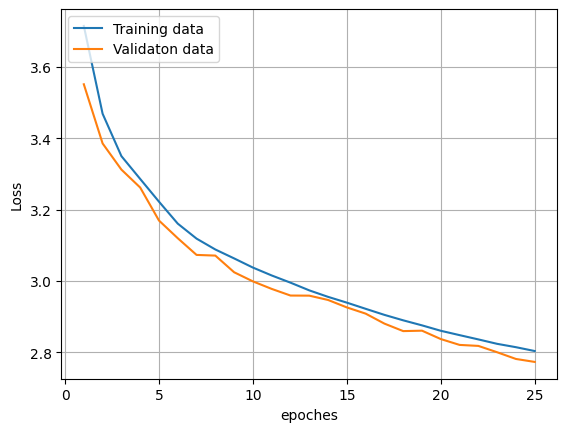

In [ ]:
x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.plot(x, loss_rate_list[0])
plt.plot(x, loss_rate_list[1])
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/LeNet5_loss_py.png")
plt.show()

Accuracy

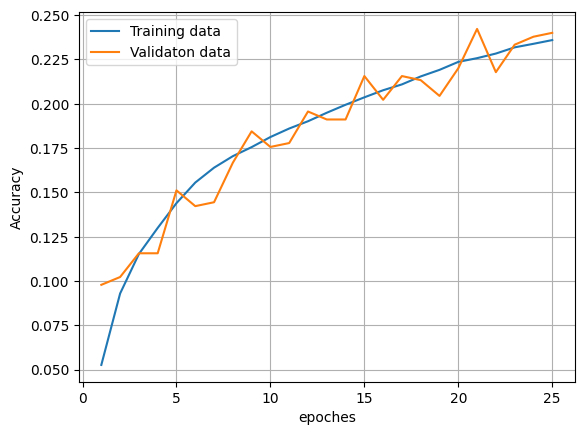

In [ ]:
x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, acc_rate_list[0])
plt.plot(x, acc_rate_list[1])
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/LeNet5_accuracy_py.png")
plt.show()

Space complexity

In [ ]:
input_size = (3, 28, 28) 
summary(lenet5, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             456
           Sigmoid-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
           Sigmoid-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
           Sigmoid-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
          Sigmoid-10                   [-1, 84]               0
           Linear-11                   [-1, 50]           4,250
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

FLOPs

In [ ]:
batch_size = 256
input_channels = 3
input_height = 28
input_width = 28
input = torch.randn(batch_size, input_channels, input_height, input_width)
input = input.to('cuda')

flops, params = profile(lenet5, inputs=(input, ))
print(f"Total FLOPs: {flops / 10**9} G FLOPs")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Total FLOPs: 0.2343936 G FLOPs


### Optional : Save the trained model and performance



Save the trained model

In [ ]:
PATH_lenet5_py = '/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/lenet5_py.pth'

In [ ]:
torch.save(lenet5.state_dict(), PATH_lenet5_py)

Save the loss

In [ ]:
np.savez("/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/loss_list_py.npz", train_loss=loss_rate_list[0], valid_loss=loss_rate_list[1])

Save the  accuracy

In [ ]:
np.savez("/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/acc_list_py.npz", train_acc=acc_rate_list[0], valid_acc=acc_rate_list[1])

## Test

### Load back in saved model

In [ ]:
PATH_lenet5_py = '/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/lenet5_py.pth'

In [ ]:
lenet5 = LeNet5().to(device)
lenet5.load_state_dict(torch.load(PATH_lenet5_py))

<All keys matched successfully>

### Evaluate on testing set

In [ ]:
start_time = time.time()
lenet5_test_pred, lenet5_test_avloss, lenet5_test_avacc = test(lenet5, criterion, test_loader, label=True)
print("Total time used:", time.time() - start_time, "sec")

100%|██████████| 1/1 [00:00<00:00, 22.79it/s]

Average test loss: 2.8310 | Average test Acc: 0.2444


In [ ]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW3/LeNet5_pytorch/' + output_name + '_test_result.csv')
  return test_result

In [ ]:
output_name = 'LeNet5_py'
LeNet5_answer = answer(test_y, lenet5_test_pred, test_dir, output_name)
LeNet5_answer

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,38
images/n02111277/n02111277_9422.JPEG,0,25
images/n02111277/n02111277_9484.JPEG,0,0
images/n02111277/n02111277_951.JPEG,0,0
images/n02111277/n02111277_9518.JPEG,0,0
...,...,...
images/n02172182/n02172182_974.JPEG,49,44
images/n02172182/n02172182_9765.JPEG,49,44
images/n02172182/n02172182_9789.JPEG,49,46
images/n02172182/n02172182_98.JPEG,49,46
